<a href="https://colab.research.google.com/github/victormurcia/CTS_Test/blob/main/CTS_Synthetic_Data_Full_Routineipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib_venn import venn2
import urllib.request
import zipfile,shutil, os,datetime
import re
import math

import spacy
#Spacy pipeline for biomedical data. Has a larger vocabulary and 50k word vectors
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_md-0.5.1.tar.gz --quiet

!pip install -q transformers
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification

!pip install -q python-Levenshtein
!pip install -q fuzzywuzzy
from fuzzywuzzy import fuzz, process

#Enable data to be extracted and downloaded from my Google Drive
from google.colab import drive, files
drive.mount('/content/drive')

pd.set_option('display.max_columns', 17)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 MB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 67.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.6.0 requires spacy<3.7.0,>=3.6.0, but you have spacy 3.4.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3

In [2]:
#Define NER stuff
tokenizer = AutoTokenizer.from_pretrained("d4data/biomedical-ner-all")
model = AutoModelForTokenClassification.from_pretrained("d4data/biomedical-ner-all")
# Define NER pipeline
pipe = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="average") #Might be worth rtying a different aggregation strategy ("simple" "first" "max" "average")

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [85]:
def process_patients_df(df, match_value, sample_frac=0.1):
    """
    Process the patients' DataFrame by sampling, modifying boolean columns, and adding a 'Match' column.

    Parameters:
        df (DataFrame): The DataFrame to process.
        match_value (int): The value to assign in the 'Match' column.
        sample_frac (float, optional): Fraction of the DataFrame to sample. Default is 0.1.

    Returns:
        DataFrame: Processed DataFrame with modified values and the 'Match' column.
    """
    # Sample from the cohort dataframe
    sampled_df = df.sample(frac=sample_frac, random_state=42)

    columns_to_check = ['ad dementia', 'mini-mental state examination', 'acetylcholinesterase inhibitors', 'designated study partner']

    bool_columns_to_check = [col for col in columns_to_check if col in sampled_df.columns]
    other_bool_columns = sampled_df.select_dtypes(include='bool').columns.difference(bool_columns_to_check)

    if match_value == 1:
        sampled_df.loc[:, bool_columns_to_check] = True
        sampled_df.loc[:, other_bool_columns] = False
    elif match_value == -1:
        sampled_df.loc[:, bool_columns_to_check] = False
        sampled_df.loc[:, other_bool_columns] = True
    sampled_df['Match'] = match_value

    return sampled_df

def create_labeled_cohort_df(cohort_df):
    """
    Create a labeled cohort DataFrame by processing and combining different patient groups.

    Parameters:
        cohort_df (DataFrame): The original cohort DataFrame.

    Returns:
        DataFrame: Labeled cohort DataFrame with 'Match' column and processed data.
    """
    # Assuming 'cohort' is your original dataframe
    perfect_patients_df = process_patients_df(cohort_df, 1)
    worst_patients_df = process_patients_df(cohort_df, -1)

    # Reset indices of worst_patients_df and perfect_patients_df
    worst_patients_df = worst_patients_df.reset_index(drop=True)
    perfect_patients_df = perfect_patients_df.reset_index(drop=True)

    # Get the row indices from df1 that you want to remove from df2
    row_indices_to_remove_worst = cohort_df.index.intersection(worst_patients_df.index)
    # Remove rows from df2 based on the row indices obtained
    mixed_patients_df = cohort_df.drop(row_indices_to_remove_worst)

    # Reset indices of mixed_patients_df for alignment
    mixed_patients_df = mixed_patients_df.reset_index(drop=True)

    # Remove rows from df1 based on the index values present in df2
    row_indices_to_remove_perfect = cohort_df.index.intersection(perfect_patients_df.index)
    mixed_patients_df = mixed_patients_df.drop(row_indices_to_remove_perfect)

    # Add a 'Match' column to mixed_patients_df
    mixed_patients_df['Match'] = 0

    # Concatenate the DataFrames to create the 'cohort' DataFrame
    cohort_df = pd.concat([perfect_patients_df, mixed_patients_df, worst_patients_df]).reset_index(drop=True)

    return cohort_df

def generate_patient_profile(cohort_df, patient_id):
    """
    Generate a patient profile based on the specified patient's index.

    Parameters:
        cohort_df (DataFrame): The cohort DataFrame containing patient information.
        patient_id (int): The index of the patient for which to generate the profile.

    Returns:
        dict: A dictionary representing the patient's profile.
    """
    if patient_id < 0 or patient_id >= len(cohort_df):
        raise IndexError("Invalid patient_id")

    # Get the row as a pandas Series
    patient_info = cohort_df.iloc[patient_id]

    # Convert the row to a dictionary
    patient_profile = patient_info.to_dict()

    return patient_profile

def process_eligibility_criteria(criteria_text):
    """
    Process the eligibility criteria text and create DataFrames for inclusion and exclusion criteria.

    Parameters:
        criteria_text (str): The eligibility criteria text.

    Returns:
        DataFrame: DataFrame containing inclusion criteria.
        DataFrame: DataFrame containing exclusion criteria.
    """
    # Split the criteria text into inclusion and exclusion criteria
    criteria_split = criteria_text.split("Exclusion Criteria:")
    inclusion_criteria = criteria_split[0].strip().replace("Inclusion Criteria:", "")
    exclusion_criteria = criteria_split[1].strip() if len(criteria_split) > 1 else ""

    # Create DataFrames for inclusion and exclusion criteria
    inclusion_list = [c.strip() for c in inclusion_criteria.split('\n') if c.strip()]
    exclusion_list = [c.strip() for c in exclusion_criteria.split('\n') if c.strip()]

    exclusion_df = pd.DataFrame({'Criteria': exclusion_list})
    inclusion_df = pd.DataFrame({'Criteria': inclusion_list})

    # Remove everything inside parentheses and hyphens
    inclusion_df['Criteria'] = inclusion_df['Criteria'].replace(r'\(.*?\)', '', regex=True).replace(r'-', '', regex=True)
    exclusion_df['Criteria'] = exclusion_df['Criteria'].replace(r'\(.*?\)', '', regex=True).replace(r'-', '', regex=True)

    return inclusion_df, exclusion_df

def run_ner_on_criteria(criteria_df, model, tokenizer,criteria,entity_types,score_threshold=0.2,keys_to_remove=[]):
    # Define NER pipeline
    pipe = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="average") #Might be worth rtying a different aggregation strategy ("simple" "first" "max" "average")
    # Define a function that takes a piece of text and returns model predictions
    def get_entities(text):
        result = pipe(text)
        return result

    # Apply NER to the 'Criteria' column
    criteria_df['entities'] = criteria_df['Criteria'].apply(get_entities)

    # Explode the 'entities' column into separate rows
    criteria_df = criteria_df.explode('entities')

    # Create new columns
    criteria_df['entity_group'] = criteria_df['entities'].apply(lambda x: x['entity_group'] if pd.notnull(x) else None)
    criteria_df['score'] = criteria_df['entities'].apply(lambda x: x['score'] if pd.notnull(x) else None)
    criteria_df['word'] = criteria_df['entities'].apply(lambda x: x['word'] if pd.notnull(x) else None)
    criteria_df = criteria_df.reset_index(drop=True)

    # Filter and clean up criteria dataFrame
    criteria_df = criteria_df[(criteria_df['entity_group'].isin(entity_types)) & (criteria_df['score'] > score_threshold)].reset_index() #If accuracy score is below threshold remove that entity
    criteria_df['combined_word'] = criteria_df['word'].apply(lambda x: x.replace('##', '').replace("'", '').replace("  ", '') if x is not None else '')

    # Create a new DataFrame to store the combined rows
    combined_criteria_df = pd.DataFrame(columns=criteria_df.columns)

    # Iterate over the rows to combine words that were overly tokenized
    i = 0
    while i < len(criteria_df):
        row = criteria_df.iloc[i].copy()
        # If the next word(s) starts with '##', combine them
        while (i + 1) < len(criteria_df) and criteria_df.iloc[i + 1]['word'] and criteria_df.iloc[i + 1]['word'].startswith('##'):
            row['combined_word'] += criteria_df.iloc[i + 1]['combined_word']
            # Combine other relevant columns as well (such as 'score')
            i += 1
        combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)
        i += 1

    criteria_df = combined_criteria_df
    #Remove entities that have less than 2 characters
    criteria_df = criteria_df[criteria_df['combined_word'].str.len() > 2].drop_duplicates(subset=['combined_word'])

    #Remove duplicate entities
    #combined_criteria_df = combined_criteria_df.drop_duplicates(subset=['combined_word'])

    # Create criteria dictionary
    if criteria == 'exclusion':
      criteria_dict = {key: False for key in criteria_df['combined_word']}
    elif criteria == 'inclusion':
      criteria_dict = {key: True for key in criteria_df['combined_word']}

    for key in keys_to_remove:
      criteria_dict.pop(key, None)

    return criteria_df,criteria_dict

def normalize_key(key):
    key = key.lower()  # Convert to lowercase
    key = ''.join(e for e in key if e.isalnum() or e.isspace())  # Remove punctuation
    return key.strip()  # Strip white spaces

def match_patient_profile_to_eligibility(patient_profile, eligibility_criteria_dict, threshold=70):
    # Normalize keys for eligibility_criteria_dict
    criteria_normalized = {normalize_key(k): v for k, v in eligibility_criteria_dict.items()}

    # Initialize filtered_patient_profile with keys from eligibility_criteria_dict and values set to NaN
    filtered_patient_profile = {key: np.nan for key in eligibility_criteria_dict.keys()}

    # Match keys using fuzzy matching
    for patient_key, patient_value in patient_profile.items():
        normalized_patient_key = normalize_key(patient_key)
        match_key, score = process.extractOne(normalized_patient_key, criteria_normalized.keys())
        if score > threshold:
            filtered_patient_profile[match_key] = patient_value

    return filtered_patient_profile

def dice_coefficient(dict1, dict2):
    common_keys = set(dict1.keys()).intersection(set(dict2.keys()))

    if not common_keys:
        return 0.0  # No common keys, so similarity is 0

    matches = 0
    for key in common_keys:
        val1 = dict1[key]
        val2 = dict2[key]

        # Check for NaN values
        if isinstance(val1, (float, int)) and np.isnan(val1) and isinstance(val2, (float, int)) and np.isnan(val2):
            matches += 1
        elif val1 == val2:
            matches += 1

    total = len(dict1) + len(dict2)

    return 2 * matches / total

def calculate_sdi(patient_profile, eligibility_criteria_dict):
    return dice_coefficient(patient_profile, eligibility_criteria_dict)

# Standardize keys between patient and clinical trial dictionaries
def standardize_keys(patient_profile, eligibility_criteria_dict):
    return match_patient_profile_to_eligibility(patient_profile, eligibility_criteria_dict)

def process_and_fill_cohort_data(file_path, exclude_columns, columns_to_convert, columns_to_drop, new_boolean_columns, columns_to_rename):
    """
    Process and fill cohort data based on specified operations.

    Args:
        file_path (str): Path to the CSV file containing the cohort data.
        exclude_columns (list): List of columns to exclude from random filling.
        columns_to_convert (list): List of columns to be converted to boolean type.
        columns_to_drop (list): List of columns to be dropped from the DataFrame.
        new_boolean_columns (list): List of new boolean columns to be added.
        columns_to_rename (dict): Dictionary for renaming specific columns in the DataFrame.

    Returns:
        pd.DataFrame: Processed cohort DataFrame.
    """

    # Load the .csv file
    cohort = pd.read_csv(file_path)

    # Convert the specified columns to bool
    cohort[columns_to_convert] = cohort[columns_to_convert].astype(bool)

    # Drop specified columns
    cohort = cohort.drop(columns=columns_to_drop)

    # Remove unnecessary terms from columns names
    words_to_remove = ['-condition', '-health factor', '-result numeric (original)', '-medication', '-interpretation', '-procedure', '-lab test', '-medication (administered)', '(administered)']
    cohort.columns = cohort.columns.str.replace('|'.join(map(re.escape, words_to_remove)), '', regex=True)

    # Rename specific columns in the DataFrame
    cohort = cohort.rename(columns=columns_to_rename)

    # Select boolean columns from the DataFrame
    boolean_columns = cohort.select_dtypes(include=[bool]).columns.tolist()

    # Select boolean columns to fill randomly
    random_fill_columns = [col for col in boolean_columns if col not in exclude_columns]

    # Fill the selected columns with random True/False values
    for column in random_fill_columns:
        if column not in exclude_columns:
            true_probability = np.random.uniform(0.3, 0.7)  # Random value between 0.3 and 0.7
            false_probability = 1 - true_probability
            cohort[column] = np.random.choice([True, False], size=len(cohort), p=[true_probability, false_probability])

    # Add new boolean columns and fill them randomly with True or False
    for column in new_boolean_columns:
        cohort[column] = np.random.choice([True, False], size=len(cohort))

    return cohort

def clinical_trial_matching(cohort,criteria_text,keys_to_remove, model, tokenizer,entity_types):
    """
    Perform clinical trial matching on a cohort of participants based on eligibility criteria.

    Args:
        cohort (pd.DataFrame): Original cohort data.
        criteria_text (str): Text containing inclusion and exclusion criteria.
        keys_to_remove (list): List of keys to remove from criteria dictionary.
        model: NER model for extracting criteria entities.
        tokenizer: Tokenizer for processing the text.
        entity_types (list) : entity categories to keep

    Returns:
        inclusion_df (pd.DataFrame): DataFrame containing processed inclusion criteria.
        exclusion_df (pd.DataFrame): DataFrame containing processed exclusion criteria.
        cohort_subset (pd.DataFrame): Subset of the cohort with matched participants and calculated SDI values.
    """
    cohort_df = create_labeled_cohort_df(cohort)

    inclusion_df, exclusion_df = process_eligibility_criteria(criteria_text)

    inclusion_df, inclusion_dict = run_ner_on_criteria(inclusion_df, model, tokenizer, 'inclusion', entity_types, keys_to_remove=keys_to_remove)
    exclusion_df, exclusion_dict = run_ner_on_criteria(exclusion_df, model, tokenizer, 'exclusion', entity_types, keys_to_remove=keys_to_remove)

    eligibility_criteria_dict = {**inclusion_dict, **exclusion_dict}

    #cohort_df['standardized_profile'] = cohort_df.apply(lambda row: standardize_keys(row.to_dict(), eligibility_criteria_dict), axis=1)
    #cohort_df['sdi'] = cohort_df.apply(lambda row: calculate_sdi(row['standardized_profile'], eligibility_criteria_dict), axis=1)

    subset_match_1 = cohort_df[cohort_df['Match'] == 1].sample(n=100)
    subset_match_0 = cohort_df[cohort_df['Match'] == 0].sample(n=800)
    subset_match_minus_1 = cohort_df[cohort_df['Match'] == -1].sample(n=100)

    cohort_subset = pd.concat([subset_match_1, subset_match_0, subset_match_minus_1]).reset_index(drop=True)
    cohort_subset['standardized_profile'] = cohort_subset.apply(lambda row: standardize_keys(row.to_dict(), eligibility_criteria_dict), axis=1)
    cohort_subset['sdi'] = cohort_subset.apply(lambda row: calculate_sdi(row['standardized_profile'], eligibility_criteria_dict), axis=1)

    return eligibility_criteria_dict,inclusion_df,exclusion_df,cohort_subset

def visualize_bool_value_differences_and_histogram(clinical_trial_profile, patient_profile, cohort_subset,trial_name):
    """
    Visualizes the differences in boolean values between two dictionaries and creates a histogram of the 'sdi' column.

    Parameters:
        clinical_trial_profile (dict): The dictionary representing the clinical trial profile.
        patient_profile (dict): The dictionary representing the patient's profile.
        cohort_subset (DataFrame): The DataFrame containing the 'sdi' column and 'Match' column.
        trial_name (str) : String for identifying clinical trial ID
    """
    keys = list(clinical_trial_profile.keys())
    values1 = list(clinical_trial_profile.values())
    values2 = list(patient_profile.values())

    # Create a list of colors based on value differences
    colors = ['green' if val1 == val2 else 'red' if not pd.isna(val1) and not pd.isna(val2) else 'gray' for val1, val2 in zip(values1, values2)]

    # Create subplots
    plt.figure(figsize=(15, 6))  # Adjust the size as needed

    # Right subplot - Histogram of 'sdi' column
    plt.subplot(1, 2, 1)
    plot = sns.histplot(data=cohort_subset, x='sdi', bins=20, edgecolor='black', hue='Match', multiple='stack', alpha=0.8)
    plt.xlabel('Sørensen–Dice Coefficient')
    plt.ylabel('Frequency')
    plt.title('Distribution of Sørensen–Dice Coefficient for ' + trial_name)

    # Left subplot - Visualize boolean value differences
    plt.subplot(1, 2, 2)
    plt.bar(keys, [1] * len(keys), color=colors)
    plt.xlabel('Keys')
    plt.ylabel('Boolean Value Differences')
    plt.title('Differences in Boolean Values between Dictionaries')
    plt.xticks(rotation=90)
    plt.yticks([0, 1])

    # Create custom legend
    legend_elements = [
        Patch(color='red', label='Not a Match'),
        Patch(color='green', label='Match'),
        Patch(color='gray', label='Missing')
    ]
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# NCT05602727

In [ ]:
# URL of the zip file
zip_url = "https://github.com/victormurcia/CTS_Test/raw/main/MDClone/NCT05602727.zip"

# Destination directory for the CSV file
csv_directory = "/content/drive/MyDrive/"

# Download the zip file
urllib.request.urlretrieve(zip_url, csv_directory + "NCT05602727.zip")

# Extract the CSV file from the zip
with zipfile.ZipFile(csv_directory + "NCT05602727.zip", 'r') as zip_ref:
    zip_ref.extractall(csv_directory)

# Get the name of the extracted CSV file
extracted_files = zip_ref.namelist()
extracted_csv_file = extracted_files[0]  # Assuming the CSV file is the first file in the zip

# Rename and move the extracted CSV file
new_csv_file = csv_directory + "NCT05602727.csv"
os.rename(csv_directory + extracted_csv_file, new_csv_file)

In [95]:
# List of columns to be converted to bool
columns_to_convert = [
        "mmse-health factor",
        "achei-medication",
        "designated study partner-health factor",
        "cerebrovascular disease-condition",
        "cns disease-condition",
        "epilepsy-condition",
        "brain function infection-condition",
        "major depressive disorder-condition",
        "bipolar disorder-condition",
        "delirium-condition",
        "schizophrenia -condition",
        "malignancy -condition",
        "qt prolongation-health factor",
        "no alcoholism -health factor",
        "no drug abuse-health factor",
        "anticholinergics-medication (administered)",
        "neuroleptics-medication",
        "anticonvulsants-medication",
        "narcotics-medication",
        "psychotropic agents-medication (administered)",
        "diseases of liver-condition",
        "nursing home-health factor"
    ]

columns_to_drop = ['thyroid-stimulating hormone-lab test', 'thyroid-stimulating hormone-interpretation']

# Define list of columns to exclude
exclude_columns = ['ad dementia', 'mini-mental state examination', 'acetylcholinesterase inhibitors', 'designated study partner']

columns_to_rename = {'achei': 'acetylcholinesterase inhibitors', 'alzheimers disease dementia': 'ad dementia',
                                    'mmse': 'mini-mental state examination', 'no alcoholism ': 'alcoholism', 'no drug abuse': 'drug dependency / abuse',
                                    'anticholinergics ': 'cns-penetrant anticholinergic', 'qt prolongation': 'qtc', 'cns disease': 'central nervous system disease',
                                    'major surgery': 'surgical procedure'}

new_boolean_columns = ['glutamatergic agents', 'coronavirus', 'continuous direct medical care']

# Provide the path to the CSV file
file_path = '/content/drive/MyDrive/NCT05602727.csv'  # Replace with your actual file path

# Call the function to process and fill the cohort data
cohort = process_and_fill_cohort_data(file_path, exclude_columns, columns_to_convert, columns_to_drop, new_boolean_columns, columns_to_rename)

#Process eligibility criteria
criteria_text = """
Inclusion Criteria:

Has mild to moderate AD dementia based on the national institute of neurological and communicative diseases and stroke/Alzheimer's Disease and related disorders association (NINCDS-ADRDA) criteria.
Has mini-mental state examination (MMSE) score between 12-22 (inclusive) at screening.
Is using acetylcholinesterase inhibitors (AChEI) therapy for management of AD dementia at Screening and during the study. These medications must be at stable approved dose levels ≥3 months before the first dose of study intervention and the regimens must remain constant throughout the study to the extent that is clinically appropriate.
Has a designated study partner who can fulfill the requirements of this study. The study partner will need to spend sufficient time with the participant to be familiar with their overall function and behavior and be able to provide adequate information about the participant needed for the study including, knowledge of functional and basic activities of daily life, work/educational history, cognitive performance, emotional/psychological state, and general health status.

Exclusion Criteria:

Has a known history of stroke or cerebrovascular disease that is clinically important in the investigator's opinion.
Has diagnosis of a clinically relevant central nervous system (CNS) disease other than AD dementia (with protocol-specified exceptions).
Has a history of seizures or epilepsy within the 10 years preceding Screening.
Has any other major CNS trauma, or infections that affect brain function.
Has evidence of a clinically relevant or unstable psychiatric disorder, based on criteria from the diagnostic and statistical manual of mental disorders (fifth edition), including schizophrenia or other psychotic disorder, bipolar disorder, major depression, or delirium. Major depression in remission is not exclusionary.
Has a severe, acute, or chronic medical or psychiatric condition or laboratory abnormality that may increase the risk associated with study participation or administration intervention.
Has a history of malignancy occurring within the 5 years immediately before Screening, except for a participant who has been adequately treated for 1 or more of the following: basal cell or squamous cell skin cancer; in situ cervical cancer; localized prostate carcinoma; who has undergone potentially curative therapy with no evidence of recurrence for ≥3 years post-therapy, and who is deemed to be at low risk for recurrence.
Has a risk factor for QTc prolongation.
Has a history of alcoholism or drug dependency/abuse within the 5 years preceding screening.
Has a known allergy or intolerance to the active or inert ingredients in MK-1942.
Has received any anti-amyloid agents or antibodies, or any of the following medications: CNS-penetrant anticholinergics, neuroleptics, anticonvulsants, narcotics, glutamatergic agents, agents with possible psychotropic effects, and experimental acute respiratory syndrome coronavirus 2 (COVID-19) therapies.
Has liver disease, including but not limited to chronic viral hepatitis, non-viral hepatitis, cirrhosis, malignancies, autoimmune liver diseases.
Has an abnormal thyroid-stimulating hormone (TSH) value if confirmed by abnormal T4 value.
Resides in a nursing home or assisted care facility with need for direct continuous medical care and nursing supervision. Participant may reside in such facilities provided continuous direct medical care is not required and a qualified study partner is available for coparticipation and the participant is physically able to attend all required study visits.
Had major surgical procedure or donated or lost >1 unit of blood (approximately 500 mL) within the 4 weeks before screening."""

#Remove keys that correspond to the same concept from criteria dictionary
keys_to_remove = ['dementia', 'alzheimers disease','stroke','seizures','psychiatric condition','medications','assisted care facility','intolerance','antiamyloid agents',
                      'acute respiratory syndrome','agents','facilities','prostate','recurrence','activities','related disorders','institute of neurological and communicative diseases']

entity_types = ['Disease_disorder', 'Medication', 'Diagnostic_procedure','Sign_symptom','History','Nonbiological_location','Clinical_event','Therapeutic_procedure','Activity'] #Only keep entities of these types

eligibility_criteria_dict,inclusion_df,exclusion_df,cohort_subset = clinical_trial_matching(cohort, criteria_text, keys_to_remove, model, tokenizer,entity_types)
cohort_subset

<ipython-input-85-e954569f77d6>:156: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)
<ipython-input-85-e954569f77d6>:156: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)


,date of birth,gender at birth,ethnicity,ad dementia,mini-mental state examination,acetylcholinesterase inhibitors,designated study partner,cerebrovascular disease,...,nursing home,surgical procedure,glutamatergic agents,coronavirus,continuous direct medical care,Match,standardized_profile,sdi
0,1925.666667,Male,Not Hispanic or Latino,True,True,True,True,False,...,False,False,False,False,False,1,"{'state examination': True, 'acetylcholinester...",0.677966
1,1925.583333,Male,Not Hispanic or Latino,True,True,True,True,False,...,False,False,False,False,False,1,"{'state examination': True, 'acetylcholinester...",0.677966
2,1945.250000,Male,Not Hispanic or Latino,True,True,True,True,False,...,False,False,False,False,False,1,"{'state examination': True, 'acetylcholinester...",0.677966
3,1943.500000,Male,Not Hispanic or Latino,True,True,True,True,False,...,False,False,False,False,False,1,"{'state examination': True, 'acetylcholinester...",0.677966
4,1931.083333,Male,Hispanic or Latino,True,True,True,True,False,...,False,False,False,False,False,1,"{'state examination': True, 'acetylcholinester...",0.677966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1924.000000,Male,Not Hispanic or Latino,False,False,False,False,True,...,True,True,True,True,True,-1,"{'state examination': False, 'acetylcholineste...",0.000000
996,1928.416667,Male,Not Hispanic or Latino,False,False,False,False,True,...,True,True,True,True,True,-1,"{'state examination': False, 'acetylcholineste...",0.000000
997,1924.083333,Male,Not Hispanic or Latino,False,False,False,False,True,...,True,True,True,True,True,-1,"{'state examination': False, 'acetylcholineste...",0.000000
998,1934.833333,Male,censored,False,False,False,False,True,...,True,True,True,True,True,-1,"{'state examination': False, 'acetylcholineste...",0.000000


In [10]:
cohort.columns

Index(['date of birth', 'gender at birth', 'ethnicity', 'ad dementia',
       'mini-mental state examination', 'acetylcholinesterase inhibitors',
       'designated study partner', 'cerebrovascular disease',
       'central nervous system disease', 'epilepsy',
       'brain function infection', 'major depressive disorder',
       'bipolar disorder', 'delirium', 'schizophrenia ', 'malignancy ', 'qtc',
       'alcoholism', 'drug dependency / abuse',
       'cns-penetrant anticholinergic', 'neuroleptics', 'anticonvulsants',
       'narcotics', 'psychotropic agents ', 'diseases of liver',
       'thyroid-stimulating hormone', 'nursing home', 'surgical procedure',
       'glutamatergic agents', 'coronavirus',
       'continuous direct medical care'],
      dtype='object')

In [11]:
eligibility_criteria_dict

{'state examination': True,
 'acetylcholinesterase inhibitors': True,
 'ad dementia': True,
 'cerebrovascular disease': False,
 'central nervous system disease': False,
 'epilepsy': False,
 'infections': False,
 'schizophrenia': False,
 'depression': False,
 'abnormality': False,
 'treated': False,
 'curative': False,
 'therapy': False,
 'qtc': False,
 'alcoholism': False,
 'drug dependency / abuse': False,
 'allergy': False,
 'cnspenetrant anticholinergics': False,
 'neuroleptics': False,
 'anticonvulsants': False,
 'glutamatergic agents': False,
 'coronavirus': False,
 'thyroidstimulating hormone': False,
 'nursing home': False,
 'medical care': False,
 'coparticipation': False,
 'surgical procedure': False,
 'donated': False}

In [12]:
cohort_subset['standardized_profile'][0]

{'state examination': True,
 'acetylcholinesterase inhibitors': True,
 'ad dementia': True,
 'cerebrovascular disease': False,
 'central nervous system disease': False,
 'epilepsy': False,
 'infections': False,
 'schizophrenia': False,
 'depression': False,
 'abnormality': nan,
 'treated': nan,
 'curative': nan,
 'therapy': nan,
 'qtc': False,
 'alcoholism': False,
 'drug dependency / abuse': nan,
 'allergy': nan,
 'cnspenetrant anticholinergics': False,
 'neuroleptics': False,
 'anticonvulsants': False,
 'glutamatergic agents': False,
 'coronavirus': False,
 'thyroidstimulating hormone': 2.02039709993066,
 'nursing home': False,
 'medical care': False,
 'coparticipation': nan,
 'surgical procedure': False,
 'donated': nan,
 'drug dependency  abuse': False}

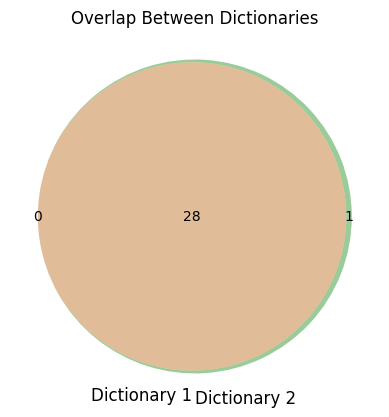

In [29]:
def visualize_overlap(dict1, dict2):
    set1 = set(dict1.keys())
    set2 = set(dict2.keys())

    venn = venn2([set1, set2], ('Dictionary 1', 'Dictionary 2'))

    plt.title("Overlap Between Dictionaries")
    plt.show()

visualize_overlap(eligibility_criteria_dict, cohort_subset['standardized_profile'][0])

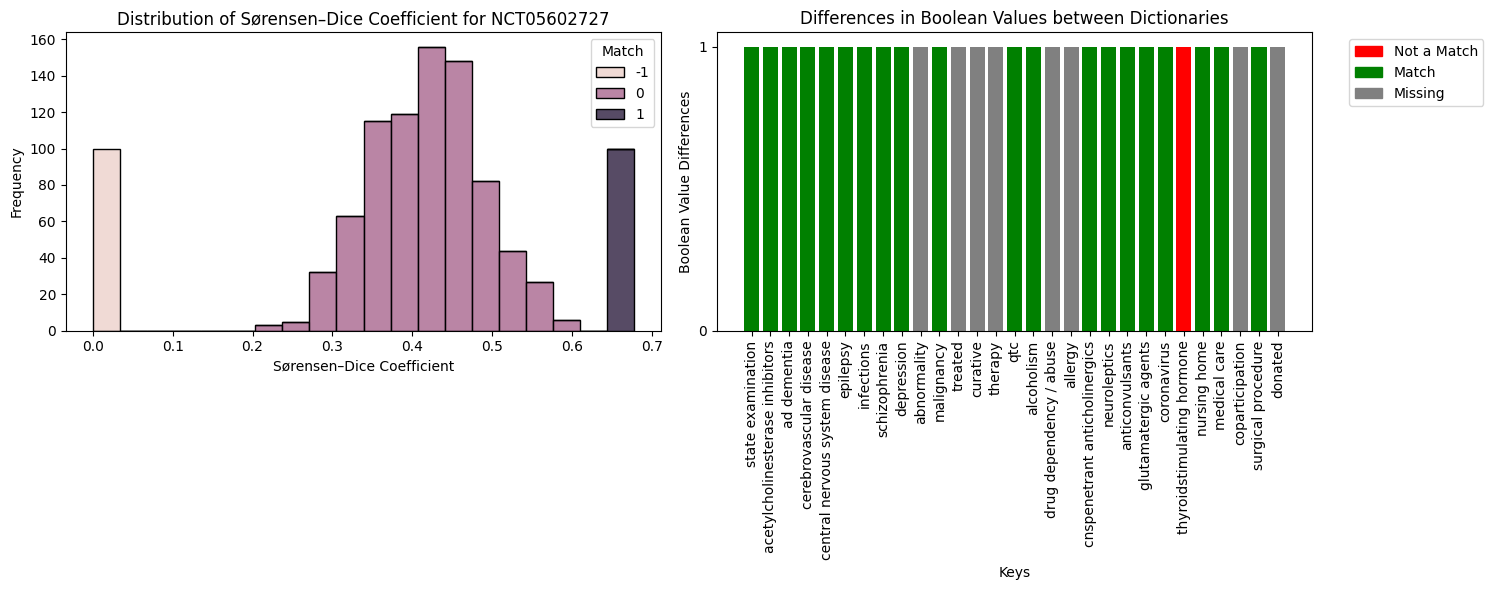

In [96]:
visualize_bool_value_differences_and_histogram(eligibility_criteria_dict, cohort_subset['standardized_profile'][0], cohort_subset,'NCT05602727')

In [13]:
inclusion_df

,index,Criteria,entities,entity_group,score,word,combined_word
1,3,Has mild to moderate AD dementia based on the ...,"{'entity_group': 'Disease_disorder', 'score': ...",Disease_disorder,0.879325,dementia,dementia
2,4,Has mild to moderate AD dementia based on the ...,"{'entity_group': 'Disease_disorder', 'score': ...",Disease_disorder,0.956756,institute of neurological and communicative di...,institute of neurological and communicative di...
3,5,Has mild to moderate AD dementia based on the ...,"{'entity_group': 'Disease_disorder', 'score': ...",Disease_disorder,0.999792,stroke,stroke
4,6,Has mild to moderate AD dementia based on the ...,"{'entity_group': 'Disease_disorder', 'score': ...",Disease_disorder,0.999423,alzheimer ' s disease,alzheimers disease
5,7,Has mild to moderate AD dementia based on the ...,"{'entity_group': 'Disease_disorder', 'score': ...",Disease_disorder,0.998893,related disorders,related disorders
6,8,Has minimental state examination score betwee...,"{'entity_group': 'Diagnostic_procedure', 'scor...",Diagnostic_procedure,0.997241,state examination,state examination
7,10,Is using acetylcholinesterase inhibitors ther...,"{'entity_group': 'Medication', 'score': 0.9152...",Medication,0.915297,acetylcholinesterase inhibitors,acetylcholinesterase inhibitors
8,11,Is using acetylcholinesterase inhibitors ther...,"{'entity_group': 'Disease_disorder', 'score': ...",Disease_disorder,0.998362,ad dementia,ad dementia
9,12,Is using acetylcholinesterase inhibitors ther...,"{'entity_group': 'Medication', 'score': 0.5483...",Medication,0.548304,medications,medications
10,16,Has a designated study partner who can fulfill...,"{'entity_group': 'History', 'score': 0.5757947...",History,0.575795,activities,activities


In [14]:
exclusion_df

,index,Criteria,entities,entity_group,score,word,combined_word
0,0,Has a known history of stroke or cerebrovascul...,"{'entity_group': 'Disease_disorder', 'score': ...",Disease_disorder,0.880616,stroke,stroke
1,1,Has a known history of stroke or cerebrovascul...,"{'entity_group': 'Disease_disorder', 'score': ...",Disease_disorder,0.703231,cerebrovascular disease,cerebrovascular disease
2,2,Has diagnosis of a clinically relevant central...,"{'entity_group': 'Disease_disorder', 'score': ...",Disease_disorder,0.999408,central nervous system disease,central nervous system disease
4,4,Has a history of seizures or epilepsy within t...,"{'entity_group': 'Sign_symptom', 'score': 0.99...",Sign_symptom,0.999423,seizures,seizures
5,5,Has a history of seizures or epilepsy within t...,"{'entity_group': 'Disease_disorder', 'score': ...",Disease_disorder,0.347930,epilepsy,epilepsy
6,7,"Has any other major CNS trauma, or infections ...","{'entity_group': 'Disease_disorder', 'score': ...",Disease_disorder,0.999632,infections,infections
7,9,Has evidence of a clinically relevant or unsta...,"{'entity_group': 'History', 'score': 0.8831544...",History,0.883154,schizophrenia,schizophrenia
8,11,Has evidence of a clinically relevant or unsta...,"{'entity_group': 'Sign_symptom', 'score': 0.92...",Sign_symptom,0.929951,depression,depression
9,14,"Has a severe, acute, or chronic medical or psy...","{'entity_group': 'Disease_disorder', 'score': ...",Disease_disorder,0.434140,psychiatric condition,psychiatric condition
10,15,"Has a severe, acute, or chronic medical or psy...","{'entity_group': 'Sign_symptom', 'score': 0.56...",Sign_symptom,0.562237,abnormality,abnormality


## NCT01627301

In [59]:
# List of columns to be converted to bool
columns_to_convert = []

columns_to_drop = []#['thyroid-stimulating hormone-lab test', 'thyroid-stimulating hormone-interpretation']

# Define list of columns to exclude
exclude_columns = ['ad dementia', 'mini-mental state examination', 'acetylcholinesterase inhibitors', 'designated study partner']

columns_to_rename = {}#{'achei': 'acetylcholinesterase inhibitors', 'alzheimers disease dementia': 'ad dementia'}

new_boolean_columns = []#['glutamatergic agents', 'coronavirus', 'continuous direct medical care']

# Provide the path to the CSV file
file_path = 'https://raw.githubusercontent.com/victormurcia/CTS_Test/main/MDClone/NCT01627301.csv' # Replace with your actual file path

# Call the function to process and fill the cohort data
cohort = process_and_fill_cohort_data(file_path, exclude_columns, columns_to_convert, columns_to_drop, new_boolean_columns, columns_to_rename)
cohort

,date of birth,gender at birth,ethnicity,ptsd,prehypertensive-bp (diastolic),prehypertensive-bp (systolic),normotensive-bp (diastolic),normotensive-bp (systolic),heart or vascular disease,no illicit drug use,alcohol use,not pregnant,autonomic dysfunction,monoamine oxidase inhibitors,systemic disease,clonidine
0,1949.250000,Male,Not Hispanic or Latino,Prolonged posttraumatic stress disorder,68.012479,121.987348,66.015037,113.988552,True,True,False,False,True,True,False,False
1,1961.250000,Male,Unknown by patient,Prolonged posttraumatic stress disorder,70.995628,128.000288,70.996418,117.026206,False,False,False,True,False,True,True,False
2,1948.333333,Male,Not Hispanic or Latino,Prolonged posttraumatic stress disorder,66.010573,121.991798,63.998684,112.007183,False,False,True,True,True,False,True,True
3,1975.000000,Male,Declined to answer,Prolonged posttraumatic stress disorder,68.991453,120.015557,74.017613,107.982677,False,False,True,False,False,True,True,False
4,1945.583333,Male,Not Hispanic or Latino,Prolonged posttraumatic stress disorder,63.989674,121.972885,74.983100,114.026633,True,False,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7214,1955.416667,Male,Not Hispanic or Latino,"Post-traumatic stress disorder, unspecified",70.982959,123.990784,78.002753,113.978597,True,False,True,True,False,True,False,True
7215,1969.833333,Female,Not Hispanic or Latino,"Post-traumatic stress disorder, unspecified",76.006708,122.022642,54.988417,104.016164,True,True,False,True,False,True,True,False
7216,1992.500000,Male,Not Hispanic or Latino,"Post-traumatic stress disorder, unspecified",79.012908,127.018314,71.986515,114.995570,False,True,True,True,True,True,True,False
7217,1984.166667,Male,Not Hispanic or Latino,"Post-traumatic stress disorder, unspecified",63.994368,121.024321,62.012309,114.990781,False,True,True,True,True,False,True,True


In [66]:
cohort.columns

Index(['date of birth', 'gender at birth', 'ethnicity', 'ptsd',
       'prehypertensive-bp (diastolic)', 'prehypertensive-bp (systolic)',
       'normotensive-bp (diastolic)', 'normotensive-bp (systolic)',
       'heart or vascular disease', 'no illicit drug use', 'alcohol use',
       'not pregnant', 'autonomic dysfunction',
       'monoamine oxidase inhibitors ', 'systemic disease', 'clonidine '],
      dtype='object')

In [88]:
# Assuming 'cohort' is your original dataframe
cohort_df = create_labeled_cohort_df(cohort)

#Process eligibility criteria
criteria_text = """
Inclusion Criteria:

- Prehypertensive and normotensive veterans with PTSD, and prehypertensive and normotensive veterans without PTSD (controls)

Exclusion Criteria:

- Heart or vascular disease
- Illicit drug use
- Excessive alcohol use (>2 drinks per day)
- Pregnancy
- Autonomic dysfunction
- Medications known to affect SNS (clonidine)
- Treatment with monoamine oxidase (MAO) inhibitors within the last 14 days
- Any serious systemic disease
"""

keys_to_remove = []
entity_types = ['Disease_disorder', 'Medication', 'Diagnostic_procedure','Sign_symptom','History','Nonbiological_location','Clinical_event','Therapeutic_procedure','Activity'] #Only keep entities of these types

eligibility_criteria_dict,inclusion_df,exclusion_df,cohort_subset = clinical_trial_matching(cohort, criteria_text, keys_to_remove, model, tokenizer,entity_types)
cohort_subset

<ipython-input-85-e954569f77d6>:156: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)
<ipython-input-85-e954569f77d6>:156: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)


,date of birth,gender at birth,ethnicity,ptsd,prehypertensive-bp (diastolic),prehypertensive-bp (systolic),normotensive-bp (diastolic),normotensive-bp (systolic),...,not pregnant,autonomic dysfunction,monoamine oxidase inhibitors,systemic disease,clonidine,Match,standardized_profile,sdi
0,1943.916667,Male,Not Hispanic or Latino,Prolonged posttraumatic stress disorder,77.992773,125.006447,70.009546,112.994477,...,False,False,False,False,False,1,"{'prehypertensive': 125.00644723834463, 'normo...",0.461538
1,1964.000000,Male,Not Hispanic or Latino,Prolonged posttraumatic stress disorder,75.991515,127.978200,60.008938,106.023496,...,False,False,False,False,False,1,"{'prehypertensive': 127.9782003868966, 'normot...",0.461538
2,1979.416667,Male,Not Hispanic or Latino,Prolonged posttraumatic stress disorder,75.999377,124.004067,77.985748,118.022049,...,False,False,False,False,False,1,"{'prehypertensive': 124.00406698622793, 'normo...",0.461538
3,1971.583333,Male,Not Hispanic or Latino,"Post-traumatic stress disorder, unspecified",76.001403,121.989754,70.994833,109.983437,...,False,False,False,False,False,1,"{'prehypertensive': 121.98975433444852, 'normo...",0.461538
4,1948.166667,Male,Not Hispanic or Latino,Prolonged posttraumatic stress disorder,73.986668,121.978299,75.007983,112.001784,...,False,False,False,False,False,1,"{'prehypertensive': 121.97829917956456, 'normo...",0.461538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1952.500000,Male,Not Hispanic or Latino,Prolonged posttraumatic stress disorder,59.990754,120.024872,69.013468,113.025345,...,True,True,True,True,True,-1,"{'prehypertensive': 120.024872391613, 'normote...",0.000000
996,1985.083333,Male,Not Hispanic or Latino,"Post-traumatic stress disorder, chronic",78.014964,128.015889,76.935465,106.007835,...,True,True,True,True,True,-1,"{'prehypertensive': 128.01588880174413, 'normo...",0.000000
997,1959.500000,Female,Not Hispanic or Latino,Prolonged posttraumatic stress disorder,72.001283,125.994640,77.001425,119.015601,...,True,True,True,True,True,-1,"{'prehypertensive': 125.99464045625972, 'normo...",0.000000
998,1990.000000,Male,Not Hispanic or Latino,Prolonged posttraumatic stress disorder,67.987202,120.992231,55.992303,99.982220,...,True,True,True,True,True,-1,"{'prehypertensive': 120.99223082270264, 'normo...",0.000000


In [89]:
exclusion_df

,index,Criteria,entities,entity_group,score,word,combined_word
0,0,Heart or vascular disease,"{'entity_group': 'Disease_disorder', 'score': ...",Disease_disorder,0.997040,heart,heart
1,1,Heart or vascular disease,"{'entity_group': 'Disease_disorder', 'score': ...",Disease_disorder,0.994884,vascular disease,vascular disease
2,2,Illicit drug use,"{'entity_group': 'Activity', 'score': 0.884828...",Activity,0.884829,illicit drug use,illicit drug use
3,4,Excessive alcohol use,"{'entity_group': 'Activity', 'score': 0.815286...",Activity,0.815286,alcohol use,alcohol use
4,5,Pregnancy,"{'entity_group': 'History', 'score': 0.2509009...",History,0.250901,pregnancy,pregnancy
5,6,Autonomic dysfunction,"{'entity_group': 'Disease_disorder', 'score': ...",Disease_disorder,0.833135,autonomic dysfunction,autonomic dysfunction
6,7,Medications known to affect SNS,"{'entity_group': 'Medication', 'score': 0.9995...",Medication,0.999538,medications,medications
7,8,Medications known to affect SNS,"{'entity_group': 'Disease_disorder', 'score': ...",Disease_disorder,0.498977,sns,sns
8,9,Treatment with monoamine oxidase inhibitors ...,"{'entity_group': 'Medication', 'score': 0.8329...",Medication,0.832916,monoamine oxidase inhibitors,monoamine oxidase inhibitors
9,12,Any serious systemic disease,"{'entity_group': 'Disease_disorder', 'score': ...",Disease_disorder,0.999778,systemic disease,systemic disease


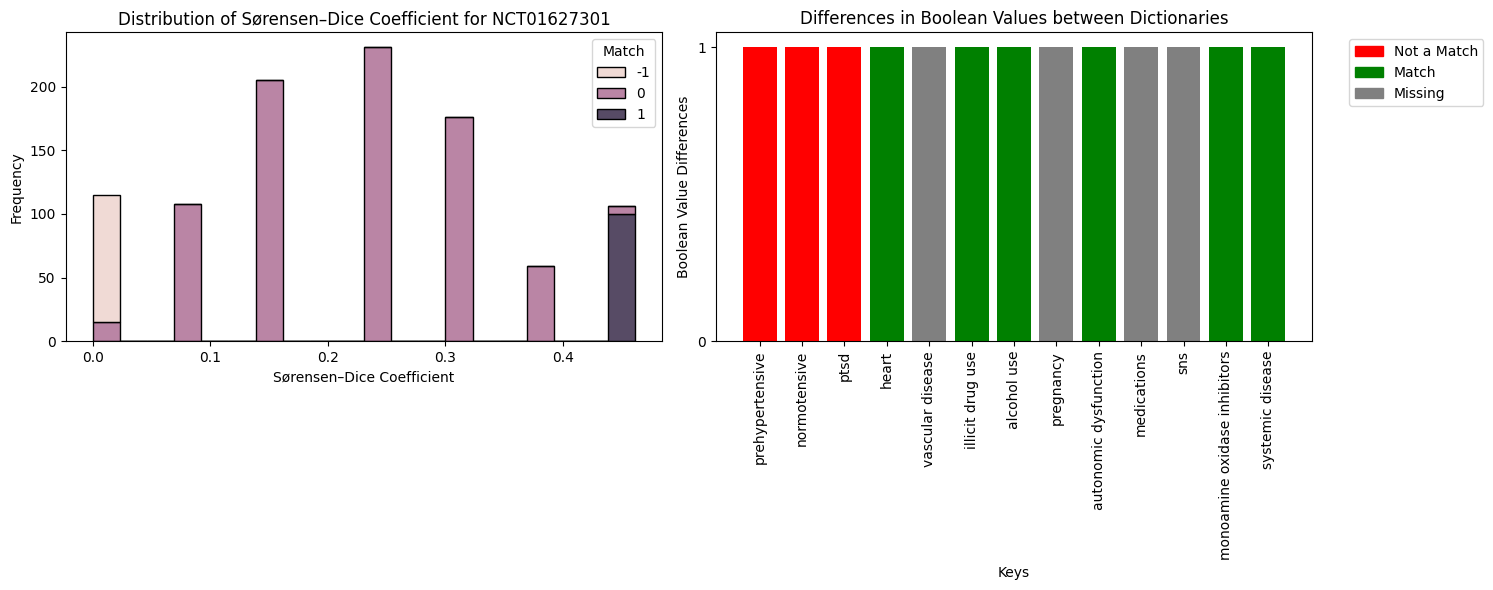

In [90]:
visualize_bool_value_differences_and_histogram(eligibility_criteria_dict, cohort_subset['standardized_profile'][0], cohort_subset,'NCT01627301')

In [91]:
eligibility_criteria_dict

{'prehypertensive': True,
 'normotensive': True,
 'ptsd': True,
 'heart': False,
 'vascular disease': False,
 'illicit drug use': False,
 'alcohol use': False,
 'pregnancy': False,
 'autonomic dysfunction': False,
 'medications': False,
 'sns': False,
 'monoamine oxidase inhibitors': False,
 'systemic disease': False}

In [92]:
cohort_subset['standardized_profile'][0]

{'prehypertensive': 125.00644723834463,
 'normotensive': 112.9944772479274,
 'ptsd': 'Prolonged posttraumatic stress disorder',
 'heart': False,
 'vascular disease': nan,
 'illicit drug use': False,
 'alcohol use': False,
 'pregnancy': nan,
 'autonomic dysfunction': False,
 'medications': nan,
 'sns': nan,
 'monoamine oxidase inhibitors': False,
 'systemic disease': False}

# Semantic Mapping on Extracted Entities

In [ ]:
import requests

api_key = "7eaeb202-9f78-47b2-b276-5081d0845752"
endpoint = "https://uts-ws.nlm.nih.gov/rest/search/current"
# Function to perform semantic mapping using UMLS API
def perform_semantic_mapping(term):
    params = {
        "string": term,
        "apiKey": api_key
    }

    response = requests.get(endpoint, params=params)
    data = response.json()

    if "result" in data and "results" in data["result"]:
        results = data["result"]["results"]

        if results:
            return [result["ui"] for result in results]

    return []

# Perform semantic mapping for "fracture of carpal bone"
term = "dementia"
cui_list = perform_semantic_mapping(term)

# Print the Concept Unique Identifiers (CUIs)
print("Semantic mapping for term:", term)
if cui_list:
    for cui in cui_list:
        print("CUI:", cui)
else:
    print("No CUIs found for the term.")

In [ ]:
import matplotlib.pyplot as plt
import re

sentence = "Dr. Smith prescribed 500mg of Amoxicillin to Jane Doe on 05/01/2023."

lexicons = {
    "PERSON": ["Dr. Smith", "Jane Doe"],
    "MEDICATION": ["Amoxicillin"],
    "DATE": [r"\d{2}/\d{2}/\d{4}"]
}

colors = {
    "PERSON": "red",
    "MEDICATION": "green",
    "DATE": "blue"
}

entities_found = []

for entity_type, entity_values in lexicons.items():
    for value in entity_values:
        for match in re.finditer(value, sentence):
            start, end = match.span()
            entities_found.append((start, end, entity_type))

entities_found.sort(key=lambda x: x[0])

# Manually specify x-positions for entities based on their start position in the sentence
x_positions = {
    0: 0,   # Dr. Smith
    30: 0.28, # Amoxicillin
    45: 0.405, # Jane Doe
    57: 0.52   # 05/01/2023
}

fig, ax = plt.subplots(figsize=(12, 3))
ax.text(0, 0.6, sentence, fontsize=12)

for start, end, entity_type in entities_found:
    x_pos = x_positions.get(start, start / len(sentence))

    # Annotating the recognized entity with a bounding box and label
    ax.annotate(sentence[start:end],
                xy=(x_pos, 0.6),
                color=colors[entity_type],
                fontsize=12,
                bbox=dict(facecolor='lightgray', edgecolor=colors[entity_type], boxstyle='round,pad=0.2'),
                xycoords="axes fraction")

    ax.annotate(entity_type,
                xy=(x_pos, 0.7),
                color=colors[entity_type],
                fontsize=8,
                ha='left',
                xycoords="axes fraction")

ax.axis('off')
plt.show()

In [ ]:
from spacy import displacy
from spacy.tokens import Doc, Span, Token

nlp = spacy.blank("en")

sentence = "Dr. Smith prescribed 500mg of Amoxicillin to Jane Doe on 05/01/2023."

lexicons = {
    "PERSON": ["Dr. Smith", "Jane Doe"],
    "MEDICATION": ["Amoxicillin"],
    "DATE": [r"\d{2}/\d{2}/\d{4}"]
}

doc = Doc(nlp.vocab, words=sentence.split())

ents = []

for entity_type, patterns in lexicons.items():
    for pattern in patterns:
        for match in re.finditer(pattern, sentence):
            start_char, end_char = match.span()
            start_token = len(doc[:start_char].text.split())
            end_token = start_token + len(doc[start_char:end_char].text.split())
            span = Span(doc, start_token, end_token, label=entity_type)
            ents.append(span)

doc.ents = ents
displacy.render(doc, style="ent", jupyter=True)